# Monocular Depth Estimation Using U-Net and MobileNetV3 on Jetson TX2 NX Devices

This model aims for monocular depth estimation using a U-Net architecture with a MobileNetV3 as the encoder. The model is trained on the DIODE Indoor Dataset.

The model are built using the pytorch and then will be converted to ONNX then to a TensorRT engine for inference on the Jetson TX2 NX device.

The model is trained using the Adam optimizer with a learning rate of 0.0001 (Can be changed). The model is trained using the mean squared error loss function.

For more information on the model, please refer to the following paper: https://arxiv.org/pdf/2004.04572.pdf

An Aditional information can be accessed in the following link: https://github.com/alinstein/Depth_estimation, https://www.kaggle.com/code/muhammadhafil/monocular-depth-estimation and https://www.kaggle.com/code/harits/indoor-depth-estimation-u-net

The dataset used for training can be found in the following link: https://diode-dataset.org/ or https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import albumentations as A
from PIL import Image
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import gc
import time

# torch
import torch
import torchvision
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection

# warnings
import warnings
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split

# Class
from DiodeLoader import Dataset
from Model import Model

d:\Brian\UNet-MobiletV3\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check for how many GPUs are available
print("GPU Available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())

GPU Available:  False
Number of GPUs:  0


In [3]:
# torch.zeros(1).cuda()

AssertionError: Torch not compiled with CUDA enabled

# Hyperparameters

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.0001
HEIGHT = 192
WIDTH = 256

# Dataset Preparation

In [ ]:
train_csv = "./data/nyu2_train.csv"
train_ims_path = "./data/nyu2_train_images/"
base_path = "./"

In [ ]:
df = pd.read_csv(train_csv, header=None)
df[0] = df[0].map(lambda x: os.path.join(base_path, x))
df[1] = df[1].map(lambda x: os.path.join(base_path, x))

df.head()

,0,1
0,./data/nyu2_train/living_room_0038_out/37.jpg,./data/nyu2_train/living_room_0038_out/37.png
1,./data/nyu2_train/living_room_0038_out/115.jpg,./data/nyu2_train/living_room_0038_out/115.png
2,./data/nyu2_train/living_room_0038_out/6.jpg,./data/nyu2_train/living_room_0038_out/6.png
3,./data/nyu2_train/living_room_0038_out/49.jpg,./data/nyu2_train/living_room_0038_out/49.png
4,./data/nyu2_train/living_room_0038_out/152.jpg,./data/nyu2_train/living_room_0038_out/152.png


In [ ]:
train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
len(train_df),len(val_df), len(test_df)

(45619, 4562, 507)

# Visualize the Depth Map

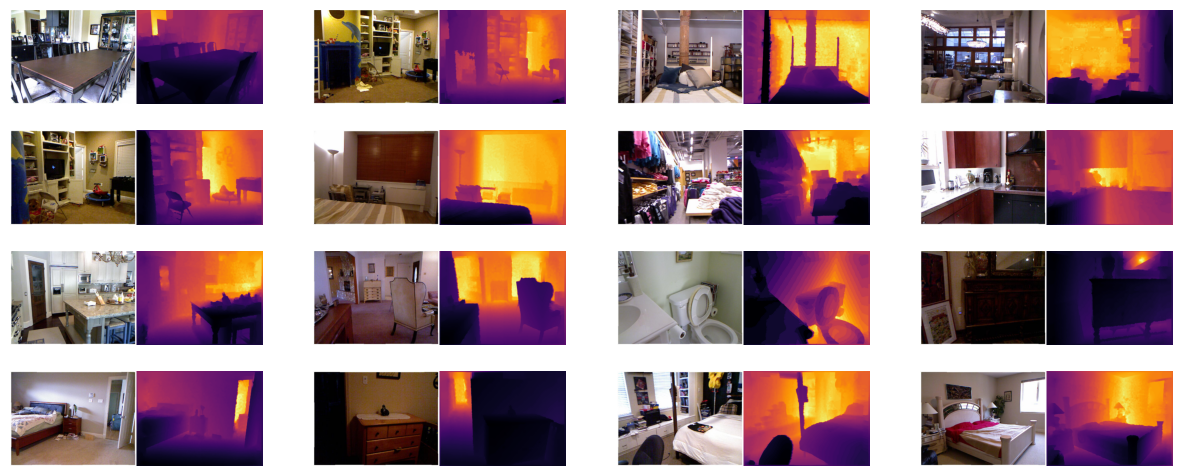

In [ ]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# Dataset

In [ ]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384,384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])

In [ ]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(45619, 4562, 507)

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds,shuffle=False,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)
len(train_dl), len(val_dl), len(test_dl)

(713, 72, 127)

# Loss Function and Metrics
The loss function used are SSIM and MSE. The SSIM is used to measure the similarity between two images, while the MSE is used to measure the difference between two images. 

The metrics used are RMSE, MAE, and SSIM. The RMSE is used to measure the difference between the predicted depth map and the ground truth depth map. The MAE is used to measure the difference between the predicted depth map and the ground truth depth map. The SSIM is used to measure the similarity between the predicted depth map and the ground truth depth map.

In [ ]:
class UnNormalize(torchvision.transforms.Normalize):
    def __init__(self,*args,**kwargs):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets,n=4,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img)*255.
        img,pred,gt = img.permute(1,2,0).numpy(), pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img,pred,gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/target/prediction' if len(title)!=0 else 'image/target/prediction'
    plt.suptitle(title)
    plt.show()

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

metrics = MetricCollection([
  SSIM(data_range=(0.1)),
  MSE()
]).to(DEVICE)

train_metrics = metrics.clone()
val_metrics = metrics.clone()

logs = pd.DataFrame()
logs[['loss_train','loss_val','ssim_train','ssim_val','mse_train','mse_val']]=None

model = Model().to(DEVICE)

loss_fn = torch.nn.MSELoss()
optimizer = Adam(model.parameters(),lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=LEARNING_RATE,epochs=EPOCHS,steps_per_epoch=(len(train_dl)))

# Scaler use CPU
scaler = torch.cuda.amp.GradScaler()

# Training

In [ ]:
BEST_SSIM = -1e9
BEST_EPOCH = -1

In [ ]:
print("Training Started...")

for epoch in tqdm(range(EPOCHS)):
    model.train()
    running_loss = 0.
    train_progress = tqdm(train_dl, total=len(train_dl))

    for img, mask in train_progress:
        with torch.cpu.amp.autocast(): # chage to cuda if you have GPU
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)
            pred = model(img)
            loss = loss_fn(pred, mask)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            train_progress.set_description(f"Epoch: {epoch+1}/{EPOCHS}, LR: {optimizer.param_groups[0]['lr']:.1e}, Loss: {running_loss:.4f}")

            train_metrics(pred, mask)

        del img, mask, pred, loss

    m = train_metrics.compute()
    _ssim, _mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
    logs.loc[epoch, ['loss_train','ssim_train','mse_train']] = (running_loss/len(train_dl), _ssim, _mse)
    train_metrics.reset()
    model.eval()

    with torch.no_grad():
        running_loss = 0.

        val_progress = tqdm(val_dl, total=len(val_dl))

        for img, mask in val_progress:
            with torch.cpu.amp.autocast(): # chage to cuda if you have GPU
                img = img.to(DEVICE)
                mask = mask.to(DEVICE)
                pred = model(img)
                loss = loss_fn(pred, mask)
                running_loss += loss.item()
                val_progress.set_description(f"Epoch: {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}")

                val_metrics(pred, mask)

            del img, mask, pred, loss

        m = val_metrics.compute()
        _ssim, _mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
        logs.loc[epoch, ['loss_val','ssim_val','mse_val']] = (running_loss/len(val_dl), _ssim, _mse)
        val_metrics.reset()

        if _ssim > BEST_SSIM:
            BEST_SSIM = _ssim
            BEST_EPOCH = epoch
            sd = model.state_dict()
            torch.save(sd, 'UnetMobilenetV3.pt')

        print(f"Epoch: {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, SSIM: {_ssim:.4f}, MSE: {_mse:.4f}, BEST SSIM: {BEST_SSIM:.4f} at Epoch: {BEST_EPOCH+1}")

        with torch.no_grad():
            imgs, masks = next(iter(test_dl))
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            preds = model(imgs)
            plot_vals(imgs.cpu(), preds.cpu(), masks.cpu(), title=f"Epoch: {epoch+1}")

        gc.collect()
        # torch.cuda.empty_cache()

Training Started...


  0%|          | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 